In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#########################################################################################################
#datasets for question 8                                                                                
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale',
     'soc.religion.christian']
ng_train = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 0)
ng_test = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 0) 

# Below is the code to convert the training dataset into pandasdata frame                                   
training_dataframe = pd.DataFrame(ng_train.data)
training_targetframe = pd.DataFrame(ng_train.target)
training_targetframe.columns = ['class']
trainingdata = pd.concat([training_dataframe,training_targetframe],axis = 1)
trainingdata.columns = ['text','class']

# Below is the code to convert the testing dataset into pandas data frame
testing_dataframe = pd.DataFrame(ng_test.data)
testing_targetframe = pd.DataFrame(ng_test.target)
testing_targetframe.columns = ['class']
testingdata = pd.concat([testing_dataframe,testing_targetframe],axis = 1)
testingdata.columns = ['text','class']
#########################################################################################################


In [2]:
#########################################################################################################
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk import pos_tag
import re

wnl = nltk.wordnet.WordNetLemmatizer()
analyzer=CountVectorizer().build_analyzer()
#regex to check digits
pattern = re.compile("[+-]?\d+(?:\.\d+)?$")

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower(),pos=penn2morphy(tag)) 
           for word, tag in pos_tag(list_word)]

def lem_rmv_digit(doc):

    word = [word for word in lemmatize_sent(analyzer(doc))]
    return (filter(lambda x: not pattern.match(x),word))
   
count_vect = CountVectorizer(min_df=3, stop_words="english",analyzer=lem_rmv_digit)
X_train_counts = count_vect.fit_transform(ng_train.data)
X_test_counts = count_vect.transform(ng_test.data)
print(X_train_counts.shape)
print(X_test_counts.shape)
#########################################################################################################

(2352, 8699)
(1565, 8699)


In [3]:
#########################################################################################################
# Feature extraction 
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
tfidf_matrix_train = tfidf.fit_transform(X_train_counts).toarray()
tfidf_matrix_test = tfidf.transform(X_test_counts).toarray()

print (tfidf_matrix_train.shape)
print (tfidf_matrix_test.shape)
#########################################################################################################

(2352, 8699)
(1565, 8699)


In [4]:
#########################################################################################################
# The below code does Dimensionality reduction with LSI Only
from sklearn.decomposition import TruncatedSVD

# Dimensionality reduction with LSI
svd = TruncatedSVD(n_components = 50, random_state = 0)
train_fitting = svd.fit_transform(tfidf_matrix_train)
test_fitting = svd.transform(tfidf_matrix_test)

# The below code is for training and testing data 
train_output = np.array(training_targetframe)
test_output = np.array(testing_targetframe)
#########################################################################################################

C:\Users\madhu.kolli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
[[287  33  41  31]
 [129 158  54  44]
 [ 44  20 320   6]
 [  2   0   9 387]]


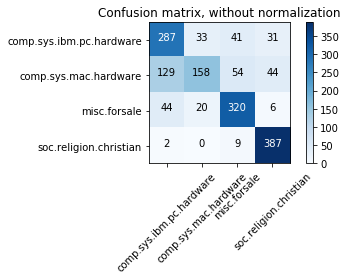

Naive Bayes Classifier: Scores - 
             precision    recall  f1-score   support

          0     0.6212    0.7321    0.6721       392
          1     0.7488    0.4104    0.5302       385
          2     0.7547    0.8205    0.7862       390
          3     0.8269    0.9724    0.8938       398

avg / total     0.7382    0.7361    0.7220      1565



In [5]:
#########################################################################################################
#Naive Bayes Classifier and for fitting the Naive Bayes Classifier 
from sklearn.naive_bayes import GaussianNB
import itertools
classifier_bayes = GaussianNB()
classifier_bayes.fit(train_fitting, train_output)

# Predicting the Test set results
test_prediction = classifier_bayes.predict(test_fitting)

# Making the Confusion Matrix
conf_matrix = confusion_matrix(test_output, test_prediction)

############################# Confustion Matrix ##########################################
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()


np.set_printoptions(precision=2)
class_names = ng_test.target_names
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
############################# Confustion Matrix ##########################################


#Calculating accuracy, precision and recall 
accuracy_bayes = (conf_matrix[0,0] + conf_matrix[1,1] + conf_matrix[2,2] + conf_matrix[3,3])/conf_matrix.sum()
print ("Naive Bayes Classifier: Scores - ")
print(classification_report(test_output,test_prediction, digits=4))
#########################################################################################################

In [6]:
#########################################################################################################
# This code creates the SVM classifier and does the one vs one and one vs rest based on LSI
from sklearn.svm import SVC
svmclassifier = SVC(kernel = 'linear', random_state = 0)

############################ For SVM/LSI Combo for One vs One ############################ 
#Creating the  svm one vs one classifier
oneonone_svmclassifier = OneVsOneClassifier(svmclassifier)
oneonone_svmclassifier.fit(train_fitting, train_output)
# Predicting the Test set results
oneonone_svmpredictor = oneonone_svmclassifier.predict(test_fitting)
# Making the Confusion Matrix, accuracy, precision, recall
conf_matrixsvm = confusion_matrix(test_output, oneonone_svmpredictor)
oneononeacc_svmclassifier = (conf_matrixsvm[0,0] + conf_matrixsvm[1,1] + conf_matrixsvm[2,2] + conf_matrixsvm[3,3])/conf_matrixsvm.sum()
print("SVM One vs One with LSI reduction")
print(classification_report(test_output, oneonone_svmpredictor,digits=4))
############################ For SVM/LSI Combo for One vs One ############################ 

############################ For SVM/LSI Combo for One vs Rest ############################ 
#Creating the one vs rest classifier
onevsrest_oneonone_svmclassifier = OneVsRestClassifier(svmclassifier)
onevsrest_oneonone_svmclassifier.fit(train_fitting,train_output)
# Predicting the Test set results
predict_onevsrest_svmclassifier = onevsrest_oneonone_svmclassifier.predict(test_fitting)
# Making the Confusion Matrix, accuracy, precision, recall
conf_matrixsvm_rest = confusion_matrix(test_output, predict_onevsrest_svmclassifier)
onevsrestacc_svmclassifier = (conf_matrixsvm_rest[0,0] + conf_matrixsvm_rest[1,1] + conf_matrixsvm_rest[2,2] + conf_matrixsvm_rest[3,3])/conf_matrixsvm_rest.sum()
print("SVM One vs Rest with LSI reduction")
print(classification_report(test_output, predict_onevsrest_svmclassifier,digits=4))
############################ For SVM/LSI Combo for One vs Rest ############################ 

#########################################################################################################

C:\Users\madhu.kolli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM One vs One with LSI reduction
             precision    recall  f1-score   support

          0     0.7762    0.8495    0.8112       392
          1     0.8567    0.7766    0.8147       385
          2     0.8878    0.9128    0.9001       390
          3     0.9896    0.9598    0.9745       398

avg / total     0.8781    0.8754    0.8758      1565

SVM One vs Rest with LSI reduction
             precision    recall  f1-score   support

          0     0.8248    0.7806    0.8021       392
          1     0.8165    0.7974    0.8068       385
          2     0.8641    0.9128    0.8878       390
          3     0.9631    0.9824    0.9726       398

avg / total     0.8677    0.8690    0.8680      1565



In [7]:
#########################################################################################################
# The below code is for dimensionality reduction with NMF
from sklearn.decomposition import NMF

svd = NMF(n_components = 50, random_state = 0)
train_fitting = svd.fit_transform(tfidf_matrix_train)
test_fitting = svd.transform(tfidf_matrix_test)

#Creating the training and testing data output
train_output = np.array(training_targetframe)
test_output = np.array(testing_targetframe)
#########################################################################################################

In [8]:
#########################################################################################################
# Naive Bayes Classifier with NMF
from sklearn.decomposition import NMF

#NB Classifier with fitting
from sklearn.naive_bayes import MultinomialNB
classifier_bayes = MultinomialNB()
classifier_bayes.fit(train_fitting, train_output)

# Predicting 
pred_NB_NMF = classifier_bayes.predict(test_fitting)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrixnmf = confusion_matrix(test_output, pred_NB_NMF)

#Calculating accuracy, precision and recall 
accuracy_NB_NMF = (conf_matrixnmf[0,0] + conf_matrixnmf[1,1] + conf_matrixnmf[2,2] + conf_matrixnmf[3,3])/conf_matrixnmf.sum()
print("Naive Bayes Scores with NMF")
print(classification_report(test_output, pred_NB_NMF, digits=4))
#########################################################################################################

Naive Bayes Scores with NMF
             precision    recall  f1-score   support

          0     0.6401    0.7985    0.7106       392
          1     0.8280    0.6000    0.6958       385
          2     0.7297    0.6231    0.6722       390
          3     0.8448    0.9849    0.9095       398

avg / total     0.7607    0.7534    0.7480      1565



C:\Users\madhu.kolli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
#########################################################################################################
# This code creates the SVM classifier and does the one vs one and one vs rest based on NMF
#SVM Classifier
from sklearn.svm import SVC
svmclassifier = SVC(kernel = 'linear', random_state = 0)

############################ For SVM/LSI Combo for One vs One ############################ 
#Creating the  svm one vs one classifier
oneonone_svmclassifier = OneVsOneClassifier(svmclassifier)
oneonone_svmclassifier.fit(train_fitting, train_output)
# Predicting the Test set results
oneonone_svmpredictor = oneonone_svmclassifier.predict(test_fitting)
# Making the Confusion Matrix, accuracy, precision, recall
conf_matrixsvm = confusion_matrix(test_output, oneonone_svmpredictor)
oneononeacc_svmclassifier = (conf_matrixsvm[0,0] + conf_matrixsvm[1,1] + conf_matrixsvm[2,2] + conf_matrixsvm[3,3])/conf_matrixsvm.sum()
print("SVM One vs One with LSI reduction")
print(classification_report(test_output, oneonone_svmpredictor,digits=4))
############################ For SVM/LSI Combo for One vs One ############################ 

############################ For SVM/LSI Combo for One vs Rest ############################ 
#Creating the one vs rest classifier
onevsrest_oneonone_svmclassifier = OneVsRestClassifier(svmclassifier)
onevsrest_oneonone_svmclassifier.fit(train_fitting,train_output)
# Predicting the Test set results
predict_onevsrest_svmclassifier = onevsrest_oneonone_svmclassifier.predict(test_fitting)
# Making the Confusion Matrix, accuracy, precision, recall
conf_matrixsvm_rest = confusion_matrix(test_output, predict_onevsrest_svmclassifier)
onevsrestacc_svmclassifier = (conf_matrixsvm_rest[0,0] + conf_matrixsvm_rest[1,1] + conf_matrixsvm_rest[2,2] + conf_matrixsvm_rest[3,3])/conf_matrixsvm_rest.sum()
print("SVM One vs Rest with NMF reduction")
print(classification_report(test_output, predict_onevsrest_svmclassifier,digits=4))
############################ For SVM/LSI Combo for One vs Rest ############################ 

#########################################################################################################

C:\Users\madhu.kolli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM One vs One with LSI reduction
             precision    recall  f1-score   support

          0     0.6573    0.5969    0.6257       392
          1     0.9167    0.4571    0.6101       385
          2     0.4978    0.8667    0.6324       390
          3     0.9615    0.8166    0.8832       398

avg / total     0.7587    0.6856    0.6890      1565

SVM One vs Rest with NMF reduction
             precision    recall  f1-score   support

          0     0.7078    0.6735    0.6902       392
          1     0.7927    0.7351    0.7628       385
          2     0.7634    0.6205    0.6846       390
          3     0.7529    0.9799    0.8515       398

avg / total     0.7540    0.7534    0.7477      1565

